# TFG - Qibo
We will try what we can do with 5 qbits, implementing different encodings.

Dominating philosophy, implementing simple gates for easy implementation.

We have encoding circuit $U_e(\vec{x})$ and parametrized circuit $U_c(\vec{\theta})$ and observable operators $\hat{O}$, we observe:

$$f(\vec{x},\vec{\theta}) = \langle 0|^{\otimes n} U_e(\vec{x})^\dagger U_c(\vec{\theta})^\dagger  \hat{O} U_c(\vec{\theta}) U_e(\vec{x})|0\rangle^{\otimes n}$$


We use Qibo for circuits logic.

Pennylane? https://pennylane.ai/ \
PyTorch, trying to make implementation agnostic NN?

% Qibo backends, slow... https://qibo.science/qibo/stable/getting-started/installation.html#installing-qibojit
% need cuda, need python > 3.8


In [6]:
import numpy as np
from qibo import Circuit, gates
import qibo
qibo.set_backend("tensorflow")

[Qibo 0.2.2|INFO|2024-06-10 06:29:09]: Using tensorflow backend on /device:CPU:0


In [7]:
# Problem with qibo. We need to have ALL parameters be the parameters we tune, to not make it messy. 
# So we can't use rotations freely

def one_qubit_unitary(circ, bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    circ.add(gates.RX(bit, symbols[0]))
    circ.add(gates.RY(bit, symbols[1]))
    circ.add(gates.RZ(bit, symbols[2]))


# https://arxiv.org/pdf/quant-ph/0308006.pdf
def two_qubit_unitary(circ, bits, symbols, full=False, onlyEnd=False):
    # bits = (a, b)
    """Make a Cirq circuit that creates a non arbitrary two qubit unitary."""
    if full and not onlyEnd:
        one_qubit_unitary(circ, bits[0], symbols[0:3])
        one_qubit_unitary(circ, bits[1], symbols[3:6])
    
    cond = full*(not onlyEnd)
        
    circ.add(gates.CNOT(bits[1],bits[0]))
    
    circ.add(gates.RZ(bits[0], symbols[0+6*cond]))
    circ.add(gates.RY(bits[1], symbols[1+6*cond]))
    
    circ.add(gates.CNOT(bits[0],bits[1]))
    
    circ.add(gates.RY(bits[1], symbols[2+6*cond]))
    
    circ.add(gates.CNOT(bits[1],bits[0]))
        
    if full and not onlyEnd: 
        one_qubit_unitary(circ, bits[0], symbols[9:12])
        one_qubit_unitary(circ, bits[1], symbols[12:])
        
    if full and onlyEnd:
        one_qubit_unitary(circ, bits[1], symbols[3:])


In [4]:
circ = Circuit(2)
param = np.random.random(16)
two_qubit_unitary(circ, (0,1), param)

print(circ.draw())

q0: ─X─RZ─o────X─
q1: ─o─RY─X─RY─o─


In [22]:
circ = Circuit(2)
circ.add(gates.X(1))
circ.execute().state()

<tf.Tensor: shape=(4,), dtype=complex128, numpy=array([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j])>

With all these kind of gates used we can use the parameter shift rule to calculate gradients. Furthermore, all gates are expressed as rotations so they have generating matrix eigenvalues $\frac12$, i.e. we end up with:

$$\frac{\partial f}{\partial \theta_i} = \frac12 \left [f(\vec{x}, \vec{\theta} + \hat{e_i}\frac\pi2) - f(\vec{x}, \vec{\theta} - \hat{e_i}\frac\pi2)\right]$$

In [8]:
from numpy import pi

# observables have to be included
def parameter_shift_exp(circ, obs, param, nrep=None, initial_state=None):
    params = np.asarray(circ.get_parameters()).copy()
    modified = params.copy()
    #for _ in range(nrep):
    modified[param] = params[param]+pi/2
    circ.set_parameters(modified)
    fp = obs.expectation(circ(initial_state,nshots=nrep).state())
    
    modified[param] = params[param]-pi/2
    circ.set_parameters(modified)
    fm = obs.expectation(circ(initial_state,nshots=nrep).state())
    
    circ.set_parameters(params)
    
    return 1/2*(fp - fm)
    

# Actually, this was implemented!!!: https://github.com/qiboteam/adiabatic-fit/blob/main/src/adiabatic-fit/psr.py

def parameter_shift(
    circuit,
    hamiltonian,
    parameter_index,
    initial_state=None,
    scale_factor=1,
    nshots=None,
    nruns=None
):
    """In this method the parameter shift rule (PSR) is implemented.
    Given a circuit U and an observable H, the PSR allows to calculate the derivative
    of the expected value of H on the final state with respect to a variational
    parameter of the circuit.
    There is also the possibility of setting a scale factor. It is useful when a
    circuit's parameter is obtained by combination of a variational
    parameter and an external object, such as a training variable in a Quantum
    Machine Learning problem. For example, performing a re-uploading strategy
    to embed some data into a circuit, we apply to the quantum state rotations
    whose angles are in the form: theta' = theta * x, where theta is a variational
    parameter and x an input variable. The PSR allows to calculate the derivative
    with respect of theta' but, if we want to optimize a system with respect its
    variational parameters we need to "free" this procedure from the x depencency.
    If the `scale_factor` is not provided, it is set equal to one and doesn't
    affect the calculation.
    Args:
        circuit (:class:`qibo.models.circuit.Circuit`): custom quantum circuit.
        hamiltonian (:class:`qibo.hamiltonians.Hamiltonian`): target observable.
        parameter_index (int): the index which identifies the target parameter in the circuit.get_parameters() list
        initial_state ((2**nqubits) vector): initial state on which the circuit acts (default None).
        scale_factor (float): parameter scale factor (default None).
    Returns:
        np.float value of the derivative of the expectation value of the hamiltonian
        with respect to the target variational parameter.
    Example:
        .. testcode::
            import qibo
            import numpy as np
            from qibo import hamiltonians, gates
            from qibo.models import Circuit
            from qibo.derivative import parameter_shift
            # defining an observable
            def hamiltonian(nqubits = 1):
                m0 = (1/nqubits)*hamiltonians.Z(nqubits).matrix
                ham = hamiltonians.Hamiltonian(nqubits, m0)
                return ham
            # defining a dummy circuit
            def circuit(nqubits = 1):
                c = Circuit(nqubits = 1)
                c.add(gates.RY(q = 0, theta = 0))
                c.add(gates.RX(q = 0, theta = 0))
                c.add(gates.M(0))
                return c
            # initializing the circuit
            c = circuit(nqubits = 1)
            # some parameters
            test_params = np.random.randn(2)
            c.set_parameters(test_params)
            test_hamiltonian = hamiltonian()
            # running the psr with respect to the two parameters
            grad_0 = parameter_shift(circuit = c, hamiltonian = test_hamiltonian, parameter_index = 0)
            grad_1 = parameter_shift(circuit = c, hamiltonian = test_hamiltonian, parameter_index = 1)
    """

    # inheriting hamiltonian's backend
    backend = hamiltonian.backend

    # getting the gate's type
    gate = circuit.associate_gates_with_parameters()[parameter_index]

    # getting the generator_eigenvalue
    generator_eigenval = gate.generator_eigenvalue()

    # defining the shift according to the psr
    s = np.pi / (4 * generator_eigenval)

    # saving original parameters and making a copy
    original = np.asarray(circuit.get_parameters()).copy()
    shifted = original.copy()

    # forward shift and evaluation
    shifted[parameter_index] += s
    circuit.set_parameters(shifted)

    forward = 0
    backward = 0


    if nshots == None:
        forward = hamiltonian.expectation(
            backend.execute_circuit(circuit=circuit, initial_state=initial_state).state()
        )

        # backward shift and evaluation
        shifted[parameter_index] -= 2 * s
        circuit.set_parameters(shifted)

        backward = hamiltonian.expectation(
            backend.execute_circuit(circuit=circuit, initial_state=initial_state).state()
        )

    else:
        
        copied = shifted.copy()

        for _ in range(nruns):

            forward += backend.execute_circuit(
                circuit=circuit, 
                initial_state=initial_state, 
                nshots=nshots
                ).expectation_from_samples(hamiltonian)

            # backward shift and evaluation
            shifted[parameter_index] -= 2 * s
            circuit.set_parameters(shifted)

            backward += backend.execute_circuit(
                circuit=circuit, 
                initial_state=initial_state, 
                nshots=nshots
                ).expectation_from_samples(hamiltonian)  

            # restoring the original circuit
            shifted = copied.copy()
            circuit.set_parameters(copied)

        forward /= nruns
        backward /= nruns
            
    circuit.set_parameters(original)
        

    return generator_eigenval * (forward - backward) * scale_factor

In [9]:
import matplotlib.pyplot as plt
from qibo.backends import GlobalBackend
from qibo.hamiltonians import SymbolicHamiltonian
backend = GlobalBackend()
from qibo.symbols import Z, X, Y

def pred(circ, obs, initial_state=None, nshots=None):
    if nshots is None:
        return obs.expectation(backend.execute_circuit(circuit=circ, initial_state=initial_state).state())
    else: return backend.execute_circuit(circuit=circ, initial_state=initial_state, nshots=nshots).expectation_from_samples(obs)
    

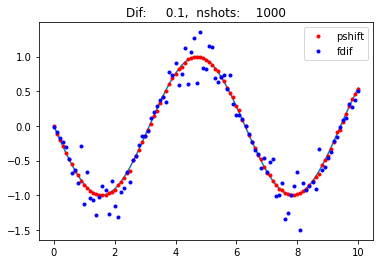

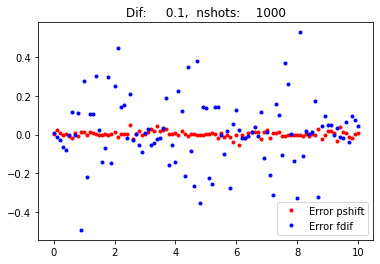

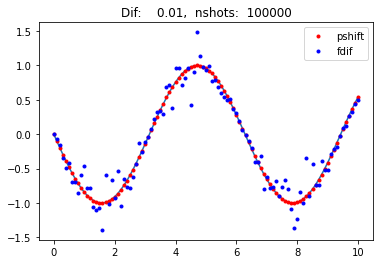

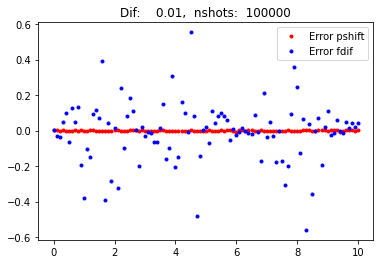

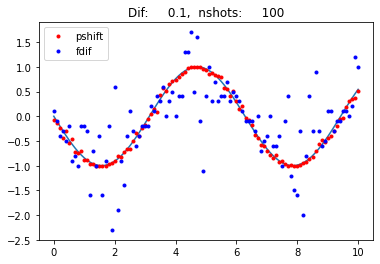

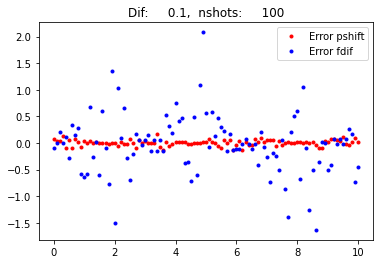

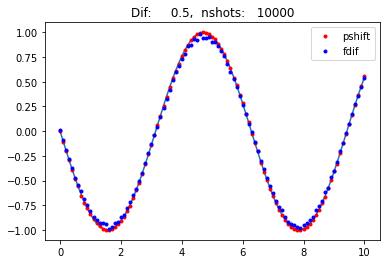

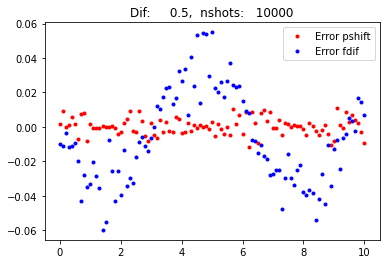

In [8]:
import matplotlib.pyplot as plt
from qibo.backends import GlobalBackend
from qibo.hamiltonians import SymbolicHamiltonian
backend = GlobalBackend()
from qibo.symbols import Z, X, Y

x = np.linspace(0, 10, 101)
y = -np.sin(x)
yexp = []
ydif = []
ddif = 1e-1
y1 = 0.

circ = Circuit(1)
circ.add(gates.RX(0, 0))
circ.add(gates.M(0))
obs = np.prod([Z(0)])
obs = SymbolicHamiltonian(obs, backend=backend)




nshots = 1000

def run(circ, obs, paramVals, ddif, nshots=None):
    yshift = []
    ydif = []
    ytemp = 0
    for it in range(len(paramVals)):
        circ.set_parameters([paramVals[it]])
        
        yshift.append(parameter_shift(circ, obs, 0, nruns=1, nshots=nshots))
        
        circ.set_parameters([paramVals[it]-ddif])
        ytemp = pred(circ, obs, nshots=nshots)
        
        circ.set_parameters([paramVals[it]+ddif])
        
        ydif.append((pred(circ,obs,nshots=nshots)-ytemp)/(2*ddif))
    
    return yshift, ydif

"""for it in range(len(x)):
    circ.set_parameters([x[it]])
    yexp.append(parameter_shift(circ, obs, 0, nruns=1, nshots=nshots))
    y1 = pred(circ, obs, nshots=nshots)
    circ.set_parameters([x[it]+ddif])
    ydif.append((pred(circ,obs,nshots=nshots)-y1)/ddif)"""

ddif = 1e-1; nshots = 1000
yexp, ydif = run(circ, obs, x, ddif, nshots)

#print(np.array(yexp))
plt.plot(x, y)
plt.plot(x, np.array(yexp), 'r.', label="pshift")
plt.plot(x, np.array(ydif), 'b.', label="fdif")
plt.legend()
plt.title("Dif: {:7},  nshots: {:7}".format(ddif, nshots))
#plt.plot(x, np.array(yexp))
plt.show()


plt.plot(x, y-np.array(yexp), 'r.', label="Error pshift")
plt.plot(x, y-np.array(ydif), 'b.', label="Error fdif")
plt.legend()
plt.title("Dif: {:7},  nshots: {:7}".format(ddif, nshots))
#plt.plot(x, np.array(yexp))
plt.show()


ddif = 1e-2; nshots = 100000
yexp, ydif = run(circ, obs, x, ddif, nshots)

#print(np.array(yexp))
plt.plot(x, y)
plt.plot(x, np.array(yexp), 'r.', label="pshift")
plt.plot(x, np.array(ydif), 'b.', label="fdif")
plt.legend()
plt.title("Dif: {:7},  nshots: {:7}".format(ddif, nshots))
#plt.plot(x, np.array(yexp))
plt.show()

plt.plot(x, y-np.array(yexp), 'r.', label="Error pshift")
plt.plot(x, y-np.array(ydif), 'b.', label="Error fdif")
plt.legend()
plt.title("Dif: {:7},  nshots: {:7}".format(ddif, nshots))
#plt.plot(x, np.array(yexp))
plt.show()


ddif = 1e-1; nshots = 100
yexp, ydif = run(circ, obs, x, ddif, nshots)

#print(np.array(yexp))
plt.plot(x, y)
plt.plot(x, np.array(yexp), 'r.', label="pshift")
plt.plot(x, np.array(ydif), 'b.', label="fdif")
plt.legend()
plt.title("Dif: {:7},  nshots: {:7}".format(ddif, nshots))
#plt.plot(x, np.array(yexp))
plt.show()

plt.plot(x, y-np.array(yexp), 'r.', label="Error pshift")
plt.plot(x, y-np.array(ydif), 'b.', label="Error fdif")
plt.legend()
plt.title("Dif: {:7},  nshots: {:7}".format(ddif, nshots))
#plt.plot(x, np.array(yexp))
plt.show()

ddif = 5e-1; nshots = 10000
yexp, ydif = run(circ, obs, x, ddif, nshots)

#print(np.array(yexp))
plt.plot(x, y)
plt.plot(x, np.array(yexp), 'r.', label="pshift")
plt.plot(x, np.array(ydif), 'b.', label="fdif")
plt.legend()
plt.title("Dif: {:7},  nshots: {:7}".format(ddif, nshots))
#plt.plot(x, np.array(yexp))
plt.show()

plt.plot(x, y-np.array(yexp), 'r.', label="Error pshift")
plt.plot(x, y-np.array(ydif), 'b.', label="Error fdif")
plt.legend()
plt.title("Dif: {:7},  nshots: {:7}".format(ddif, nshots))
#plt.plot(x, np.array(yexp))
plt.show()

circ: 

q0: ─RX─M─

circ pshift:
q0: ─H──o────o───
q1: ─RX─X─RX─X─M─


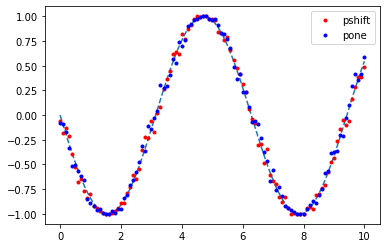

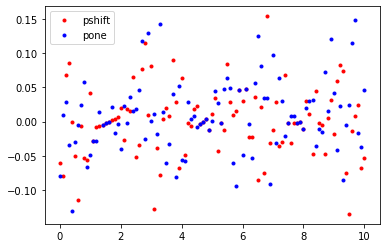

In [10]:
# Example of direct qubit measure
onecirc = Circuit(2)

paramVals = np.linspace(0, 10, 101)
y = -np.sin(paramVals)

circ = Circuit(1)
circ.add(gates.RX(0, 0))
circ.add(gates.M(0))

print("circ: \n")
print(circ.draw())

onecirc.add(gates.H(0))
onecirc.add(gates.RX(1,np.pi/2))
onecirc.add(gates.CNOT(0,1))
onecirc.add(gates.RX(1,0))
onecirc.add(gates.CNOT(0,1))
onecirc.add(gates.M(1))

print("\ncirc pshift:")
print(onecirc.draw())

obsone = np.prod([qibo.symbols.Z(1)])
obsone = qibo.hamiltonians.SymbolicHamiltonian(obsone, backend=backend)

obs = np.prod([qibo.symbols.Z(0)])
obs = qibo.hamiltonians.SymbolicHamiltonian(obs, backend=backend)

yshift = []
yone = []
ytemp = 0
for it in range(len(paramVals)):
    onecirc.set_parameters([np.pi/2, paramVals[it]])
    
    circ.set_parameters([paramVals[it]])

    yshift.append(parameter_shift(circ, obs, 0, nruns=1, nshots=100))

    #onecirc.set_parameters([np.pi/2, paramVals[it]])

    yone.append(pred(onecirc, obsone, nshots=200))

plt.plot(paramVals, y, '--')
plt.plot(paramVals, np.array(yshift), 'r.', label="pshift")
plt.plot(paramVals, np.array(yone), 'b.', label="pone")
plt.legend()
plt.show()


#plt.plot(paramVals, y, '--')
plt.plot(paramVals, np.array(yshift)-y, 'r.', label="pshift")
plt.plot(paramVals, np.array(yone)-y, 'b.', label="pone")
plt.legend()
plt.show()

In [10]:
# Example circuit simple
# Count number of excitations (1), if number of excitations > half qbits, show 1, else 0


def binary(n):
    for i in range(2**n):
        b = bin(i)[2:]
        print('0'*(n-len(b)) + b)
def generate_data(n):
    test = []
    label = []
    
    for i in range(2**n):
        b = bin(i)[2:]
        b = '0'*(n-len(b)) + b
        count = 0
        for c in b:
            if c == '1':
                count+=1
            
        label.append(-1 if count > n/2 else +1)
        test.append(b)
    return test, label

test, label = generate_data(4)
print(test)
print(label)
#binary(10)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
[1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1]


In [12]:
circ = Circuit(1)
circ.add(gates.H(0))
param = np.random.random(3)
one_qubit_unitary(circ, 0, param)
obs = np.prod([Z(0)])
obs = SymbolicHamiltonian(obs, backend=backend)
circ.add(gates.M(0))

MeasurementResult(qubits=(0,), nshots=0)

In [11]:
print(circ.draw())
circ().state()

q0: ─H─RX─RY─RZ─M─


<tf.Tensor: shape=(2,), dtype=complex128, numpy=array([0.47054528-0.41981801j, 0.77608819-0.00520551j])>

In [13]:
# Volem que l'output sigui 1
de = 1e-1
for _ in range(50):
    grad = np.zeros(3)
    pval = abs(circ().state()[0])**2
    for i in range(len(param)):
        grad[i] = parameter_shift(circ, obs, i)
    
    grad *= -2*(1-pval)
    #print(grad)
    p = np.asarray(circ.get_parameters())[:,0]
    """print(p)
    #print(p)"""
    """for i in range(len(p)):
        p[i][0]-= de*grad"""
    p -= de*grad
    #print(p)
    circ.set_parameters(p)
    print("exp: ", pval)
    #print(grad)

exp:  tf.Tensor(0.9473918925032966, shape=(), dtype=float64)
exp:  tf.Tensor(0.9484357572615303, shape=(), dtype=float64)
exp:  tf.Tensor(0.9494397962343919, shape=(), dtype=float64)
exp:  tf.Tensor(0.9504062150332668, shape=(), dtype=float64)
exp:  tf.Tensor(0.9513370611221682, shape=(), dtype=float64)
exp:  tf.Tensor(0.9522342376105635, shape=(), dtype=float64)
exp:  tf.Tensor(0.9530995156394874, shape=(), dtype=float64)
exp:  tf.Tensor(0.9539345455242265, shape=(), dtype=float64)
exp:  tf.Tensor(0.9547408667957031, shape=(), dtype=float64)
exp:  tf.Tensor(0.9555199172645727, shape=(), dtype=float64)
exp:  tf.Tensor(0.9562730412164315, shape=(), dtype=float64)
exp:  tf.Tensor(0.9570014968331086, shape=(), dtype=float64)
exp:  tf.Tensor(0.9577064629234135, shape=(), dtype=float64)
exp:  tf.Tensor(0.9583890450366588, shape=(), dtype=float64)
exp:  tf.Tensor(0.9590502810235741, shape=(), dtype=float64)
exp:  tf.Tensor(0.9596911461016636, shape=(), dtype=float64)
exp:  tf.Tensor(0.960312

In [13]:
print(circ.get_parameters())

[(0.18238542276428582,), (0.4777422638036257,), (0.3368669491456343,)]


In [18]:
n = 4
circ = Circuit(n+1)
parameters = np.random.random(3+3+3) # one 1gate for all 4 qbits, one 2gate for all qbits connecting to measure qbit
parameters = np.ones(6)
#parameters = np.random.random(12)

obs = np.prod([Z(n)])
obs = SymbolicHamiltonian(obs, backend=backend)
for bit in range(n):
    one_qubit_unitary(circ, bit, parameters[0:3])
    
for bit in range(n):
    two_qubit_unitary(circ, [bit, n], parameters[3:3+3], full=False)#, onlyEnd=False)

"""for bit in range(n):
    one_qubit_unitary(circ, bit, parameters[6:9])
    #two_qubit_unitary(circ, [bit, n], parameters[3+15:], full=True, onlyEnd=True)
    
for bit in range(n):
    two_qubit_unitary(circ, [bit, n], parameters[9:12], full=False)#, onlyEnd=False)
    
for bit in range(n):
    one_qubit_unitary(circ, bit, parameters[12:15])
    #two_qubit_unitary(circ, [bit, n], parameters[3+15:], full=True, onlyEnd=True)
    
for bit in range(n):
    two_qubit_unitary(circ, [bit, n], parameters[15:], full=False)#, onlyEnd=False)"""
    
def param_base(param):
    return param%3 + n*(param//3)    # Considerar paràmetres repetits que es consideren per separat per qibo

print(circ.draw())

initial_state = np.zeros(2**(n+1))
initial_state[0] = 1
obs.expectation(backend.execute_circuit(circuit=circ, initial_state=initial_state).state())

test, label = generate_data(4)
        

q0: ─RX─RY─RZ─X─RZ─o────X─────────────────────────────────────
q1: ─RX─RY─RZ─|────|────|─X─RZ─o────X─────────────────────────
q2: ─RX─RY─RZ─|────|────|─|────|────|─X─RZ─o────X─────────────
q3: ─RX─RY─RZ─|────|────|─|────|────|─|────|────|─X─RZ─o────X─
q4: ──────────o─RY─X─RY─o─o─RY─X─RY─o─o─RY─X─RY─o─o─RY─X─RY─o─


In [34]:
dpred = 0
dpred += parameter_shift(circ, obs, 0, initial_state)


delta = 1e-10
p1 = pred(circ, obs, initial_state)


circParam = np.asarray(circ.get_parameters())[:,0]
circParam[0] += delta
circ.set_parameters(circParam)

p2 = pred(circ, obs, initial_state)

print("Dif. Finites: ", (p2-p1)/delta)
print("Param. Shift: ", dpred)



Dif. Finites:  tf.Tensor(-0.06406319918994541, shape=(), dtype=float64)
Param. Shift:  tf.Tensor(-0.06406290613555737, shape=(), dtype=float64)


In [15]:
from time import time
#loss = []

print(circ.get_parameters()[0::3])

[(1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,)]


In [16]:
de = 0.01

# (l-pred)^2  -> gradient = -2*(l-pred)*gradPred

n = 4

init_state = np.zeros(2**(n+1))

trainSize = len(test)
loss = []
lossC = 0

bestParam = None
bestLoss = 1

nbatch = 100

for _ in range(1):
    for __ in range(nbatch): # batch
        lossC = 0
        t0 = time()
        for tes, lab in zip(test, label):
            num = int(tes, base=2)*2

            init_state[num] = 1
            
            
            for param in range(len(parameters)):
                totalGradient = 0
                predVal = pred(circ,obs,init_state)

                paramBase = param if param < 3 else param-3 + n*3
                for qbit in range(n):
                    totalGradient += parameter_shift(circ, obs, paramBase + 3*qbit, init_state)
                    #print(totalGradient)

                #Gradient descent --=+
                totalGradient *= -2*(lab-predVal)

                circParam = np.asarray(circ.get_parameters())[:,0]
                for qbit in range(n):
                    circParam[paramBase + 3*qbit] -= totalGradient*de
                circ.set_parameters(circParam)

                lossC += (lab-predVal)**2

            init_state[num] = 0
        loss.append(lossC/trainSize)
        if lossC/trainSize < bestLoss:
            bestParam = circ.get_parameters()
            bestLoss = lossC/trainSize
            
        print(time()-t0)
        
        
lossC

IndexError: list index out of range

In [19]:
# similar but faster?
de = 0.01

# (l-pred)^2  -> gradient = -2*(l-pred)*gradPred

n = 4

testFast, labelFast = (uncut[:] for uncut in generate_data(n))

init_state = np.zeros(2**(n+1))

trainSize = len(test)
loss = []
lossC = 0

bestParam = None
bestLoss = 1

nbatch = 100

print(circ.get_parameters())

for _ in range(1):
    for __ in range(nbatch): # batch
        t0 = time()
        lossC = 0
        gradient = np.zeros(len(parameters))
        for tes, lab in zip(testFast, labelFast):
            ###t0 = time()
            num = int(tes, base=2)*2

            init_state[num] = 1
            
            #totalGradient = 0
            predVal = pred(circ,obs,init_state)
            
            for param in range(len(parameters)):
                paramBase = param if param < 3 else param%3 + 3*n*(param//3)
                for qbit in range(n):
                    gradient[param] += -2*(lab-predVal)*parameter_shift(circ, obs, paramBase + 3*qbit, initial_state=init_state)
                    
            lossC += (lab-predVal)**2
            
            init_state[num] = 0
            ###print(time()-t0)
        
        loss.append(lossC/trainSize)
        if lossC/trainSize < bestLoss:
            bestParam = circ.get_parameters()
            bestLoss = lossC/trainSize
        
        circParam = np.asarray(circ.get_parameters())[:,0]
        ####gradient *= -2*(lab-predVal)
        for param in range(len(parameters)):
            paramBase = param if param < 3 else param%3 + 3*n*(param//3)
            for qbit in range(n):
                circParam[paramBase + 3*qbit] -= gradient[param]*de
        circ.set_parameters(circParam)
        
        
        
        print(time()-t0)
        
print(circ.get_parameters())
        

[(1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,)]
19.42360281944275
18.992077112197876
19.306124925613403
19.778257131576538
19.13712167739868
19.070297956466675
18.99847412109375
18.910863161087036
19.124655961990356
19.097272872924805
19.92147183418274
20.709538221359253
19.44726014137268
20.25530695915222
19.866019010543823
19.196475982666016
19.494100093841553
19.280004024505615
19.804806232452393
20.98996591567993
24.526533126831055
22.906860828399658
22.631556272506714
24.174849033355713
20.818702936172485
19.876199960708618
19.592901706695557
19.15519404411316
19.039448261260986
18.97857904434204
19.026322841644287
18.96359086036682
19.13689875602722
18.95707106590271
18.99160408973694
18.968026876449585
19.031923055648804
18.982767820358276
18.987385034561157
19.053523063659668
19.00046396255493
18.963223218917847
18.998407125473022
18.9

In [58]:
# similar but faster?
#Bucle repetint lo anterior per diversos casos:

lossList = []

Depth = 5

    
for depth in range(Depth):
    #parameters = np.random.random(3+3+3) # one 1gate for all 4 qbits, one 2gate for all qbits connecting to measure qbit
    parameters = np.ones(6+depth*3+3)
    #parameters = np.random.random(12)
    n = 4
    circ = Circuit(n+1)

    obs = np.prod([Z(n)])
    obs = SymbolicHamiltonian(obs, backend=backend)
    for bit in range(n):
        one_qubit_unitary(circ, bit, parameters[0:3])
    
    for dd in range(depth+1):
        for bit in range(n):
            two_qubit_unitary(circ, [bit, n], parameters[3*(1+dd):3*(2+dd)], full=False)#, onlyEnd=False)
            
    one_qubit_unitary(circ,n,parameters[6+depth*3:])
    
    de = 0.01

    # (l-pred)^2  -> gradient = -2*(l-pred)*gradPred

    n = 4

    testFast, labelFast = (uncut[:] for uncut in generate_data(n))

    init_state = np.zeros(2**(n+1))

    trainSize = len(test)
    loss = []
    lossC = 0

    bestParam = None
    bestLoss = 1

    nbatch = 100

    print(circ.get_parameters())

    for _ in range(1):
        for __ in range(nbatch): # batch
            t0 = time()
            lossC = 0
            gradient = np.zeros(len(parameters))
            for tes, lab in zip(testFast, labelFast):
                ###t0 = time()
                num = int(tes, base=2)*2

                init_state[num] = 1

                #totalGradient = 0
                predVal = pred(circ,obs,init_state)

                for param in range(len(parameters[:-3])):
                    paramBase = param if param < 3 else param%3 + 3*n*(param//3)
                    for qbit in range(n):
                        gradient[param] += -2*(lab-predVal)*parameter_shift(circ, obs, paramBase + 3*qbit, initial_state=init_state)
                
                for param in range(len(parameters[-3:])):
                    paramBase = param if param < 3 else param%3 + 3*n*(param//3)
                    gradient[param] += -2*(lab-predVal)*parameter_shift(circ, obs, paramBase, initial_state=init_state)


                lossC += (lab-predVal)**2

                init_state[num] = 0
                ###print(time()-t0)

            loss.append(lossC/trainSize)
            if lossC/trainSize < bestLoss:
                bestParam = circ.get_parameters()
                bestLoss = lossC/trainSize

            circParam = np.asarray(circ.get_parameters())[:,0]
            ####gradient *= -2*(lab-predVal)
            for param in range(len(parameters[:-3])):
                paramBase = param if param < 3 else param%3 + 3*n*(param//3)
                for qbit in range(n):
                    circParam[paramBase + 3*qbit] -= gradient[param]*de
            
            for param in range(len(parameters[-3:])):
                paramBase = param if param < 3 else param%3 + 3*n*(param//3)
                circParam[paramBase] -= gradient[param]*de
                    
            circ.set_parameters(circParam)



            print(time()-t0)

    print(circ.get_parameters())
    lossList.append(loss)
        

[(1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,), (1.0,)]
26.782866954803467
1037.8826489448547
24.39252018928528
2237.7653181552887
79.57230305671692
85.73158383369446
11278.918334960938
12306.603825807571
27.7986741065979
26.345759630203247
25.8241069316864
25.254420042037964
26.95966100692749
25.38443899154663
26.043602228164673
25.780562162399292
25.032007932662964
25.62944006919861
26.379043102264404
25.61455202102661
24.895511150360107
24.817476987838745
24.22956681251526
24.7746479511261
24.596603870391846
25.004416942596436
25.77175807952881
24.239460945129395
24.137215852737427
24.78330111503601
24.0169780254364
23.963629007339478
23.92939782142639
23.8552303314209
23.901737928390503
23.943740844726562
23.807759046554565
23.89459204673767
24.164702892303467
24.45721983909607
23.92586088180542
23.903414011001587
23.855877

168.72650504112244
180.36998414993286
171.69237089157104
182.6248152256012
197.84304308891296
158.93242001533508
169.30583500862122
157.46560788154602
161.6512348651886
166.5075740814209
155.64824509620667
152.52338004112244
162.3951108455658
178.5658838748932
169.6361050605774
152.87889409065247
167.1208140850067
169.3314290046692
166.36740803718567
157.64116096496582
149.62241888046265
153.9717140197754
145.50122499465942
143.33959817886353
148.18651485443115
158.44922304153442
181.92209935188293
186.18138909339905
168.62045288085938
161.17315983772278
168.74233412742615
168.05955815315247
171.06000423431396
191.57122611999512
170.07288074493408
164.32484579086304
198.57483386993408
179.31718492507935
145.40342783927917
140.16340589523315
159.56335616111755
182.86886715888977
157.90392804145813
150.51582598686218
173.08535194396973
190.06747794151306
200.53043580055237
229.1553180217743
164.80530095100403
151.43562412261963
164.47259187698364
171.7220423221588
154.4951560497284
154.2

KeyboardInterrupt: 

Text(0, 0.5, 'loss')

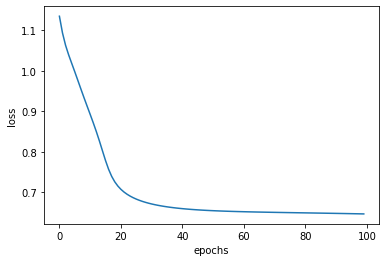

In [48]:

plt.plot(loss)#, label="qibo")
#plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
#print(loss)

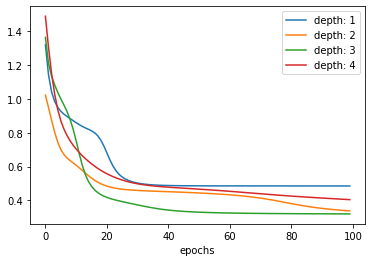

In [59]:
for i, l in enumerate( lossList ):
    plt.plot(l, label="depth: "+str(i+1))

plt.xlabel("epochs")
plt.legend()

#plt.savefig("res.pdf")
plt.show()

In [39]:
import json
#print([l.numpy() for l in loss])

In [73]:
print(circ.get_parameters()[::3])

[(4.084024027633043,), (4.084024027633043,), (3.661925822395852,), (0.6058840220271852,), (-1.5882988673759684,), (-1.5882988673759684,), (-1.1662006621387757,), (1.8898411382298903,), (0.8498777468359036,), (0.8498777468359036,), (0.8498777468359036,), (0.8498777468359036,), (0.6741492118527989,), (0.6741492118527989,), (0.6741492118527989,), (0.6741492118527989,)]


tf.Tensor(8.553376129987802, shape=(), dtype=float64)


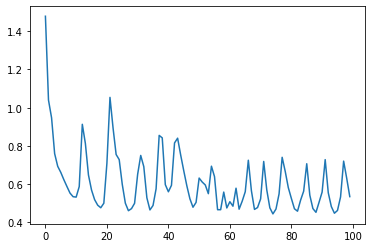

In [92]:
# de = 0.1
lossCopy = loss
plt.plot(lossCopy)

#print(lossCopy[-1])
print(lossC)

In [82]:
tempParam = circ.get_parameters()
tempParam

[(0.7135659323915163,),
 (0.27680987821280056,),
 (0.5823679745636852,),
 (0.7135659323915163,),
 (0.27680987821280056,),
 (0.5823679745636852,),
 (0.7135659323915163,),
 (0.27680987821280056,),
 (0.5823679745636852,),
 (0.7135659323915163,),
 (0.27680987821280056,),
 (0.5823679745636852,),
 (0.1969103500936643,),
 (0.7316285882900277,),
 (0.7609590323897685,),
 (0.1969103500936643,),
 (0.7316285882900277,),
 (0.7609590323897685,),
 (0.1969103500936643,),
 (0.7316285882900277,),
 (0.7609590323897685,),
 (0.1969103500936643,),
 (0.7316285882900277,),
 (0.7609590323897685,)]

In [161]:
bestParam

[(0.2811594135282053,),
 (0.21016612543934607,),
 (0.4719104953781231,),
 (0.2811594135282053,),
 (0.21016612543934607,),
 (0.4719104953781231,),
 (0.2811594135282053,),
 (0.21016612543934607,),
 (0.4719104953781231,),
 (0.2811594135282053,),
 (0.21016612543934607,),
 (0.4719104953781231,),
 (0.8850810806198145,),
 (0.4771583902270985,),
 (<tf.Tensor: shape=(), dtype=float64, numpy=-0.4937971752460146>,),
 (0.8850810806198145,),
 (0.4771583902270985,),
 (<tf.Tensor: shape=(), dtype=float64, numpy=-0.4937971752460146>,),
 (0.8850810806198145,),
 (0.4771583902270985,),
 (<tf.Tensor: shape=(), dtype=float64, numpy=-0.4937971752460146>,),
 (0.8850810806198145,),
 (0.4771583902270985,),
 (<tf.Tensor: shape=(), dtype=float64, numpy=-0.4937971752460146>,)]

In [14]:
print(orig)

NameError: name 'orig' is not defined

In [162]:
circCopy = circ.copy()

In [121]:
circCopy.set_parameters(tempParam)

In [30]:
#circ.set_parameters(bestParam)
init_state = np.zeros(2**5)
obs = np.prod([Z(4)])
obs = SymbolicHamiltonian(obs, backend=backend)
i0 = (1,1,1,1)

inum = i0[0]*2**3+i0[1]*2**2+i0[2]*2**1+i0[3]*2**0

init_state[inum*2] = 1


print(pred(circ, obs, init_state))
print(label[inum])

tf.Tensor(-0.9999986037251377, shape=(), dtype=float64)
-1


In [21]:
#circ.set_parameters(bestParam)
init_state = np.zeros(2**(n+1))
obs = np.prod([Z(4)])
obs = SymbolicHamiltonian(obs, backend=backend)
i0 = (1,1,1,1)

inum = i0[0]*2**3+i0[1]*2**2+i0[2]*2**1+i0[3]*2**0


lossC = 0
for inum in range(2**n):
    init_state[inum*2] = 1
    print(pred(circ, obs, init_state))
    print(label[inum])
    
    lossC += (pred(circ,obs,init_state)-label[inum])**2
    
    init_state[inum*2] = 0

print(lossC)
    

tf.Tensor(0.6004058621604673, shape=(), dtype=float64)
1
tf.Tensor(0.5740658775466976, shape=(), dtype=float64)
1
tf.Tensor(0.5235388971995352, shape=(), dtype=float64)
1
tf.Tensor(0.25289827116777913, shape=(), dtype=float64)
1
tf.Tensor(0.4199005167666739, shape=(), dtype=float64)
1
tf.Tensor(0.2616541840277939, shape=(), dtype=float64)
1
tf.Tensor(0.3353550722413548, shape=(), dtype=float64)
1
tf.Tensor(-0.21381292209473324, shape=(), dtype=float64)
-1
tf.Tensor(0.597387653032549, shape=(), dtype=float64)
1
tf.Tensor(0.3052594310463848, shape=(), dtype=float64)
1
tf.Tensor(0.3710817343324232, shape=(), dtype=float64)
1
tf.Tensor(0.04658839956648575, shape=(), dtype=float64)
-1
tf.Tensor(0.25960559533028044, shape=(), dtype=float64)
1
tf.Tensor(-0.2395408382373272, shape=(), dtype=float64)
-1
tf.Tensor(-0.32283261433996124, shape=(), dtype=float64)
-1
tf.Tensor(-0.5796536328230283, shape=(), dtype=float64)
-1
tf.Tensor(6.965159854097092, shape=(), dtype=float64)


In [71]:
init_state = np.zeros(2**(n+1))

lossC =  0

"""for tes, lab in zip(test, label):
            num = int(tes, base=2)*2

            init_state[num] = 1
            
            predVal = pred(circ,obs,init_state)

            lossC += (lab-predVal)**2

            init_state[num] = 0"""
            
lossC = 0
for tes, lab in zip(test, label):
    num = int(tes, base=2)*2

    init_state[num] = 1

    #lossC = 0
    for param in range(len(parameters)):
        t0 = time()
        totalGradient = 0
        
        predVal = pred(circ,obs,init_state)
        #print("pred:    ", time()-t0)
        
        #print(tes, predVal, lab)
        
        print(tes, predVal, lab, (lab-predVal)**2)
        
        
        paramBase = param if param < 3 else param-3 + n*3
        for qbit in range(n):
            t0 = time()
            totalGradient += parameter_shift_exp(circ, obs, paramBase + 3*qbit)
            #print("shift   :", time()-t0)

        #Gradient descent --=+
        t0 = time()
        totalGradient *= -2*(lab-predVal)
        
        circParam = circ.get_parameters()
        for qbit in range(n):
            circParam[paramBase + 3*qbit] -= totalGradient*de
        circ.set_parameters(circParam)

        
        
        print("----- LOSS BEFORE ----", lossC)
        lossC += (lab-predVal)**2
        print("----- LOSS AFTER ----", lossC)
        #print("descent:", time()-t0)

    init_state[num] = 0

print(lossC)

0000 tf.Tensor(0.9735953899626666, shape=(), dtype=float64) 1 tf.Tensor(0.0006972034312236482, shape=(), dtype=float64)
----- LOSS BEFORE ---- 0
----- LOSS AFTER ---- tf.Tensor(0.0006972034312236482, shape=(), dtype=float64)
0000 tf.Tensor(0.973606970730387, shape=(), dtype=float64) 1 tf.Tensor(0.0006965919940266461, shape=(), dtype=float64)
----- LOSS BEFORE ---- tf.Tensor(0.0006972034312236482, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(0.0013937954252502944, shape=(), dtype=float64)
0000 tf.Tensor(0.9736076265834568, shape=(), dtype=float64) 1 tf.Tensor(0.0006965573745582569, shape=(), dtype=float64)
----- LOSS BEFORE ---- tf.Tensor(0.0013937954252502944, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(0.002090352799808551, shape=(), dtype=float64)
0000 tf.Tensor(0.9736076311211803, shape=(), dtype=float64) 1 tf.Tensor(0.0006965571350356898, shape=(), dtype=float64)
----- LOSS BEFORE ---- tf.Tensor(0.002090352799808551, shape=(), dtype=float64)
----- LOSS AFTE

----- LOSS BEFORE ---- tf.Tensor(39.67822475502722, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(42.78674460354602, shape=(), dtype=float64)
0101 tf.Tensor(-0.7630432792556017, shape=(), dtype=float64) 1 tf.Tensor(3.1083216045283453, shape=(), dtype=float64)
----- LOSS BEFORE ---- tf.Tensor(42.78674460354602, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(45.89506620807436, shape=(), dtype=float64)
0101 tf.Tensor(-0.7630558782536828, shape=(), dtype=float64) 1 tf.Tensor(3.1083660298448645, shape=(), dtype=float64)
----- LOSS BEFORE ---- tf.Tensor(45.89506620807436, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(49.00343223791923, shape=(), dtype=float64)
0101 tf.Tensor(-0.7630562091760735, shape=(), dtype=float64) 1 tf.Tensor(3.108367196714307, shape=(), dtype=float64)
----- LOSS BEFORE ---- tf.Tensor(49.00343223791923, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(52.11179943463353, shape=(), dtype=float64)
0101 tf.Tensor(-0.7630584639512665,

----- LOSS BEFORE ---- tf.Tensor(76.66909862391032, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(76.75781408611297, shape=(), dtype=float64)
1010 tf.Tensor(0.7021597570044689, shape=(), dtype=float64) 1 tf.Tensor(0.08870881034763703, shape=(), dtype=float64)
----- LOSS BEFORE ---- tf.Tensor(76.75781408611297, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(76.84652289646061, shape=(), dtype=float64)
1010 tf.Tensor(0.7021597485652147, shape=(), dtype=float64) 1 tf.Tensor(0.08870881537473614, shape=(), dtype=float64)
----- LOSS BEFORE ---- tf.Tensor(76.84652289646061, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(76.93523171183534, shape=(), dtype=float64)
1010 tf.Tensor(0.7021597014511023, shape=(), dtype=float64) 1 tf.Tensor(0.08870884343969652, shape=(), dtype=float64)
----- LOSS BEFORE ---- tf.Tensor(76.93523171183534, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(77.02394055527503, shape=(), dtype=float64)
1010 tf.Tensor(0.7021872082997658,

----- LOSS BEFORE ---- tf.Tensor(93.88182167698825, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(93.89226525267873, shape=(), dtype=float64)
1111 tf.Tensor(-0.8978062098400791, shape=(), dtype=float64) -1 tf.Tensor(0.010443570747249949, shape=(), dtype=float64)
----- LOSS BEFORE ---- tf.Tensor(93.89226525267873, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(93.90270882342598, shape=(), dtype=float64)
1111 tf.Tensor(-0.897806300146563, shape=(), dtype=float64) -1 tf.Tensor(0.010443552289734362, shape=(), dtype=float64)
----- LOSS BEFORE ---- tf.Tensor(93.90270882342598, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(93.91315237571571, shape=(), dtype=float64)
1111 tf.Tensor(-0.8978025563590354, shape=(), dtype=float64) -1 tf.Tensor(0.010444317486748138, shape=(), dtype=float64)
----- LOSS BEFORE ---- tf.Tensor(93.91315237571571, shape=(), dtype=float64)
----- LOSS AFTER ---- tf.Tensor(93.92359669320246, shape=(), dtype=float64)
tf.Tensor(93.9235966932024

## Error self correction

The secondary purpose of quantum machine learning is correcting noise in the system. In principle, as long as it is consistent, the learning process optimizes taking noise into account, therefore combating it.

In [37]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
#loss.backwards() ## gradient is calculaed with mean error squared...
n


def fcost(params):
    cost = 0

    return cost

for n in range(steps):
    opt.zero_grad()
    loss = cost_fn(params)
    loss.backward()
    opt.step()

    if loss < best_cost:
        best_cost = loss
        best_params = params

opt = torch.optim.Adam([parameters], lr=0.1)

In [84]:
"""import numpy as np
from qibo import Circuit, gates


c = Circuit(2)

#c.add(gates.Z(0))
c.add(gates.X(1))

result = c()
print(result.state())"""

'import numpy as np\nfrom qibo import Circuit, gates\n\n\nc = Circuit(2)\n\n#c.add(gates.Z(0))\nc.add(gates.X(1))\n\nresult = c()\nprint(result.state())'